# Unsupervised Learning Trading Strategy

* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

# All Packages Needed:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
!pip install pandas-datareader
!pip install yfinance
!pip install pandas_ta

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-05-25'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-27 A        42.996662   45.820000   45.849998   45.369999   45.549999   
           AAL      30.416386   31.650000   31.840000   31.410000   31.600000   
           AAPL     23.042532   25.087500   25.117500   24.812500   24.860001   
           ABBV     44.441608   62.709999   63.200001   61.900002   61.990002   
           ABT      33.919998   39.299999   39.400002   38.919998   39.040001   
...                       ...         ...         ...         ...         ...   
2024-05-24 XYL     144.250000  144.250000  145.089996  143.020004  144.779999   
           YUM     137.649994  137.649994  137.979996  136.690002  136.889999   
           ZBH     116.410004  116.410004  116.529999  115.440002  116.019997   
           ZBRA    327.000000  327.000000  327.000000  322.600006  325.309998   
           ZTS     170.070007  170.070007  172.270004  169.729996  171.570007   

Price                   volume  
date       ticker               
2016-05-27 A         1822700.0  
           AAL       8573700.0  
           AAPL    145364800.0  
           ABBV      5768000.0  
           ABT      12339400.0  
...                        ...  
2024-05-24 XYL       1477100.0  
           YUM       1453200.0  
           ZBH       1084200.0  
           ZBRA       205400.0  
           ZTS       1893800.0  

[992494 rows x 6 columns]

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [3]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-05-27 A        42.996662   45.820000   45.849998   45.369999   45.549999   
           AAL      30.416386   31.650000   31.840000   31.410000   31.600000   
           AAPL     23.042532   25.087500   25.117500   24.812500   24.860001   
           ABBV     44.441608   62.709999   63.200001   61.900002   61.990002   
           ABT      33.919998   39.299999   39.400002   38.919998   39.040001   
...                       ...         ...         ...         ...         ...   
2024-05-24 XYL     144.250000  144.250000  145.089996  143.020004  144.779999   
           YUM     137.649994  137.649994  137.979996  136.690002  136.889999   
           ZBH     116.410004  116.410004  116.529999  115.440002  116.019997   
           ZBRA    327.000000  327.000000  327.000000  322.600006  325.309998   
           ZTS     170.070007  170.070007  172.270004  169.729996  171.570007   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-05-27 A         1822700.0         -0.001230        NaN       NaN   
           AAL       8573700.0         -0.000471        NaN       NaN   
           AAPL    145364800.0         -0.002152        NaN       NaN   
           ABBV      5768000.0         -0.042568        NaN       NaN   
           ABT      12339400.0         -0.007559        NaN       NaN   
...                        ...               ...        ...       ...   
2024-05-24 XYL       1477100.0          0.000098  68.324295  4.886098   
           YUM       1453200.0          0.000032  50.569502  4.896600   
           ZBH       1084200.0          0.000040  38.190232  4.768804   
           ZBRA       205400.0          0.000081  63.851556  5.723580   
           ZTS       1893800.0          0.000081  53.373278  5.075264   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-05-27 A            NaN       NaN       NaN       NaN      78.370016  
           AAL          NaN       NaN       NaN       NaN     260.780966  
           AAPL         NaN       NaN       NaN       NaN    3349.573051  
           ABBV         NaN       NaN       NaN       NaN     256.339197  
           ABT          NaN       NaN       NaN       NaN     418.552425  
...                     ...       ...       ...       ...            ...  
2024-05-24 XYL     4.952292  5.018485  0.315464  2.001636     213.071675  
           YUM     4.930458  4.964316  0.423962 -0.072034     200.032971  
           ZBH     4.795228  4.821653 -0.741663 -0.619564     126.211726  
           ZBRA    5.763489  5.803398 -0.192162  0.925236      67.165800  
           ZTS     5.131359  5.187453  0.659626  0.943332     322.078580  

[992494 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [4]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-07-31 A           75.466179   45.264515 -1.318861  3.843352  3.746726   
           AAL        401.105345   34.116325  0.633478  3.684955  3.334677   
           AAPL      3118.136287   23.928869 -1.213716  3.213437  3.110997   
           ABBV       350.139814   47.348217 -1.323269  3.873788  3.809447   
           ABT        403.487977   38.861835 -1.215132  3.695173  3.562258   
...                          ...         ...       ...       ...       ...   
2024-05-31 XYL        189.225552  144.250000  0.315464  5.018485  4.886098   
           YUM        271.015233  137.649994  0.423962  4.964316  4.896600   
           ZBH        157.543626  116.410004 -0.741663  4.821653  4.768804   
           ZBRA        98.104742  327.000000 -0.192162  5.803398  5.723580   
           ZTS        440.301822  170.070007  0.659626  5.187453  5.075264   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2016-07-31 A       3.795039         -0.000743  0.089020  63.954685  
           AAL     3.509816         -0.000845  1.764621  59.638230  
           AAPL    3.162217         -0.002745 -0.118666  66.365649  
           ABBV    3.841618         -0.039624  0.131534  66.422404  
           ABT     3.628716         -0.006625  0.735726  76.686308  
...                     ...               ...       ...        ...  
2024-05-31 XYL     4.952292          0.000098  2.001636  68.324295  
           YUM     4.930458          0.000032 -0.072034  50.569502  
           ZBH     4.795228          0.000040 -0.619564  38.190232  
           ZBRA    5.763489          0.000081  0.925236  63.851556  
           ZTS     5.131359          0.000081  0.943332  53.373278  

[46861 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [5]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-06-30 AAL      48.838982  0.508506  3.923412  3.858655  3.891033   
           AAPL     33.703403 -1.081656  3.619503  3.515703  3.567603   
           ABBV     53.369358 -1.525846  4.020166  3.924985  3.972575   
           ABT      43.018223 -1.328072  3.809783  3.734658  3.772220   
           ACN     111.341949 -1.092398  4.766373  4.703720  4.735047   
...                       ...       ...       ...       ...       ...   
2024-05-31 VZ       39.740002 -0.837714  3.732646  3.683193  3.707919   
           WFC      60.209999 -0.205359  4.151333  4.088323  4.119828   
           WMT      65.379997  1.278602  4.211769  4.059648  4.135708   
           XOM     113.419998  0.661316  4.796448  4.737796  4.767122   
           ZTS     170.070007  0.659626  5.187453  5.075264  5.131359   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2017-06-30 AAL            -0.000020  0.708564  59.919070  
           AAPL           -0.001808 -0.449877  43.606665  
           ABBV           -0.036447  0.403945  71.505846  
           ABT            -0.006063  0.466947  67.057218  
           ACN            -0.003969 -0.202201  49.971734  
...                             ...       ...        ...  
2024-05-31 VZ              0.000005 -0.092973  48.879154  
           WFC             0.000034  0.577351  54.402499  
           WMT             0.000048  2.671543  70.700013  
           XOM             0.000100 -0.382638  43.192364  
           ZTS             0.000081  0.943332  53.373278  

[12516 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [6]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2018-06-30 AAL      37.156166  0.675041  3.838545  3.636104  3.737324   
           AAPL     43.992638 -1.021954  3.861789  3.786773  3.824281   
           ABBV     70.505737 -0.280046  4.376234  4.251017  4.313625   
           ABT      55.062874 -0.957219  4.076933  4.017404  4.047169   
           ACN     150.009079 -0.629403  5.034309  4.970734  5.002521   
...                       ...       ...       ...       ...       ...   
2024-05-31 VRTX    456.950012  1.042072  6.147349  5.957095  6.052222   
           VZ       39.740002 -0.837714  3.732646  3.683193  3.707919   
           WFC      60.209999 -0.205359  4.151333  4.088323  4.119828   
           WMT      65.379997  1.278602  4.211769  4.059648  4.135708   
           XOM     113.419998  0.661316  4.796448  4.737796  4.767122   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2018-06-30 AAL            -0.000030 -1.726075  30.484776  -0.128158   
           AAPL           -0.000987 -0.315160  49.582428  -0.009418   
           ABBV           -0.029046 -1.216536  38.080446  -0.063574   
           ABT            -0.004588 -0.327912  47.018516  -0.008776   
           ACN            -0.003033  0.030994  58.053337   0.050404   
...                             ...       ...        ...        ...   
2024-05-31 VRTX            0.000117  2.841439  74.371373   0.163285   
           VZ              0.000005 -0.092973  48.879154   0.006331   
           WFC             0.000034  0.577351  54.402499   0.020839   
           WMT             0.000048  2.671543  70.700013   0.105414   
           XOM             0.000100 -0.382638  43.192364  -0.033218   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2018-06-30 AAL     -0.058566  -0.098656  -0.050518  -0.023882   -0.022526  
           AAPL     0.060393   0.034635   0.016401   0.021872    0.022450  
           ABBV    -0.020405  -0.003677  -0.004230   0.007379    0.023476  
           ABT      0.024305   0.007529   0.012748   0.016592    0.020784  
           ACN      0.040165   0.024443   0.012599   0.023607    0.025152  
...                      ...        ...        ...        ...         ...  
2024-05-31 VRTX     0.045541   0.027902   0.043067   0.030614    0.029181  
           VZ      -0.018965   0.003019   0.011552   0.020370    0.015182  
           WFC      0.022151   0.028933   0.053562   0.045310    0.037617  
           WMT      0.044198   0.039482   0.041075   0.022248    0.024798  
           XOM     -0.008201   0.030389   0.019562   0.005158    0.011648  

[10369 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [7]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0116  0.0419  0.0148  0.0118  -0.006489
           VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132

[10083 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [8]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-06-30 AAL     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.128158
           AAPL    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.009418
           ABBV    0.0048  0.0080 -0.0234  0.0079  0.0024  -0.063574
           ABT     0.0048  0.0080 -0.0234  0.0079  0.0024  -0.008776
           ACN     0.0048  0.0080 -0.0234  0.0079  0.0024   0.050404
...                   ...     ...     ...     ...     ...        ...
2024-03-31 VRTX    0.0283 -0.0116  0.0419  0.0148  0.0118  -0.006489
           VZ      0.0283 -0.0116  0.0419  0.0148  0.0118   0.048476
           WFC     0.0283 -0.0116  0.0419  0.0148  0.0118   0.042634
           WMT     0.0283 -0.0116  0.0419  0.0148  0.0118   0.030113
           XOM     0.0283 -0.0116  0.0419  0.0148  0.0118   0.112132

[10047 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [9]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2018-06-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2024-03-31 VRTX    0.268801  0.654605 -0.656893  0.402016  0.781699
           VZ      0.506034 -1.155973  0.600673  0.007151 -0.205277
           WFC     1.173197  0.311764  1.186080 -0.546274 -0.753656
           WMT     0.520277  0.219253 -0.675268  0.724902  0.581207
           XOM     0.808571 -0.071684  0.667508  0.882268  0.351961

[10047 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [10]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10198 entries, (Timestamp('2018-06-30 00:00:00', freq='M'), 'AAL') to (Timestamp('2024-05-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10198 non-null  float64
 1   bb_high           10198 non-null  float64
 2   bb_low            10198 non-null  float64
 3   bb_mid            10198 non-null  float64
 4   garman_klass_vol  10198 non-null  float64
 5   macd              10198 non-null  float64
 6   rsi               10198 non-null  float64
 7   return_1m         10198 non-null  float64
 8   return_2m         10198 non-null  float64
 9   return_3m         10198 non-null  float64
 10  return_6m         10198 non-null  float64
 11  return_9m         10198 non-null  float64
 12  return_12m        10198 non-null  float64
 13  Mkt-RF            10198 non-null  float64
 14  SMB               10198 non-null  floa

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [12]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [13]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2018-06-30 AAL     0.675041  3.838545  3.636104  3.737324         -0.000030   
           AAPL   -1.021954  3.861789  3.786773  3.824281         -0.000987   
           ABBV   -0.280046  4.376234  4.251017  4.313625         -0.029046   
           ABT    -0.957219  4.076933  4.017404  4.047169         -0.004588   
           ACN    -0.629403  5.034309  4.970734  5.002521         -0.003033   
...                     ...       ...       ...       ...               ...   
2024-05-31 VRTX    1.042072  6.147349  5.957095  6.052222          0.000117   
           VZ     -0.837714  3.732646  3.683193  3.707919          0.000005   
           WFC    -0.205359  4.151333  4.088323  4.119828          0.000034   
           WMT     1.278602  4.211769  4.059648  4.135708          0.000048   
           XOM     0.661316  4.796448  4.737796  4.767122          0.000100   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2018-06-30 AAL    -1.726075  30.484776  -0.128158  -0.058566  -0.098656   
           AAPL   -0.315160  49.582428  -0.009418   0.060393   0.034635   
           ABBV   -1.216536  38.080446  -0.063574  -0.020405  -0.003677   
           ABT    -0.327912  47.018516  -0.008776   0.024305   0.007529   
           ACN     0.030994  58.053337   0.050404   0.040165   0.024443   
...                     ...        ...        ...        ...        ...   
2024-05-31 VRTX    2.841439  74.371373   0.163285   0.045541   0.027902   
           VZ     -0.092973  48.879154   0.006331  -0.018965   0.003019   
           WFC     0.577351  54.402499   0.020839   0.022151   0.028933   
           WMT     2.671543  70.700013   0.105414   0.044198   0.039482   
           XOM    -0.382638  43.192364  -0.033218  -0.008201   0.030389   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2018-06-30 AAL     -0.050518  -0.023882   -0.022526  1.203745  1.490708   
           AAPL     0.016401   0.021872    0.022450  1.323367 -0.366836   
           ABBV    -0.004230   0.007379    0.023476  0.474217  0.539814   
           ABT      0.012748   0.016592    0.020784  0.794815 -0.141397   
           ACN      0.012599   0.023607    0.025152  1.218317 -0.184420   
...                      ...        ...         ...       ...       ...   
2024-05-31 VRTX     0.043067   0.030614    0.029181  0.518752  0.066294   
           VZ       0.011552   0.020370    0.015182  0.470120 -0.422551   
           WFC      0.053562   0.045310    0.037617  1.080621 -0.107186   
           WMT      0.041075   0.022248    0.024798  0.612173 -0.408517   
           XOM      0.019562   0.005158    0.011648  1.086346  0.168548   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2018-06-30 AAL     0.457738  0.156545  0.819837        0  
           AAPL   -0.621158  0.445064  0.631679        2  
           ABBV   -0.203445  0.547029  0.437896        0  
           ABT    -0.448155  0.268239  0.934197        1  
           ACN    -0.264094  0.338300  0.108284        2  
...                     ...       ...       ...      ...  
2024-05-31 VRTX   -0.902270  0.055129  0.861414        3  
           VZ      0.200716  0.215215  0.265803        1  
           WFC     1.572779 -0.759948 -0.840890        2  
           WMT    -0.361941  0.218439  0.694626        3  
           XOM     0.824618 -0.508576  0.469072        1  

[10198 rows x 19 columns]

In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


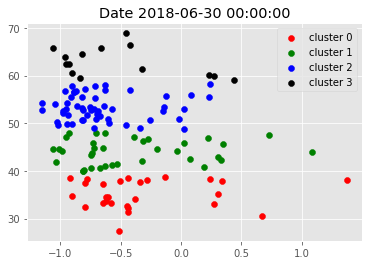

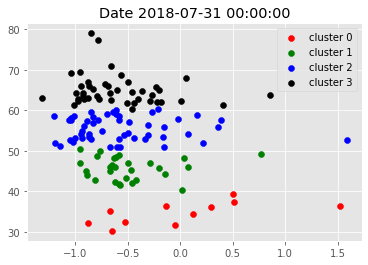

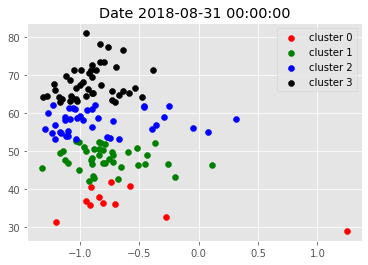

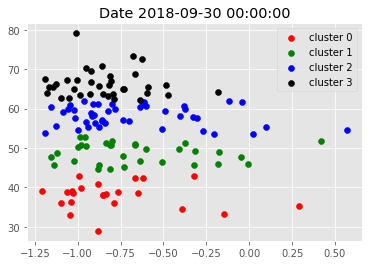

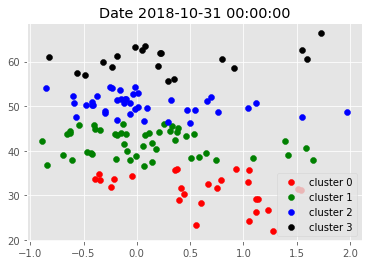

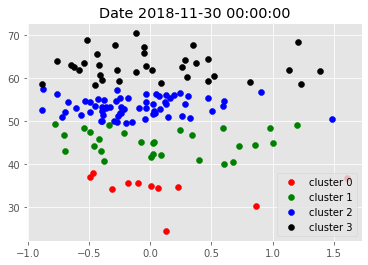

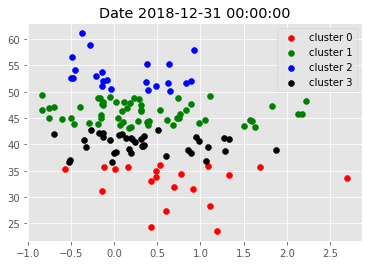

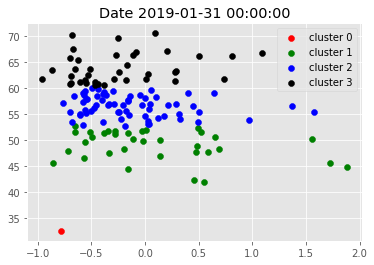

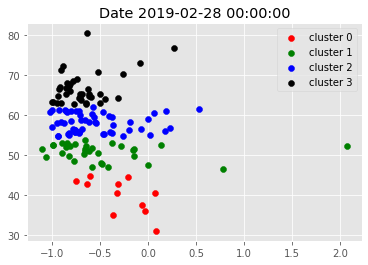

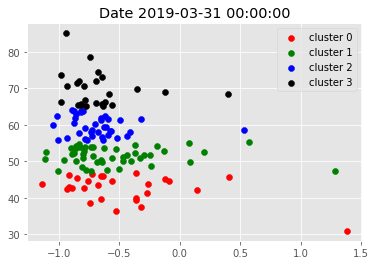

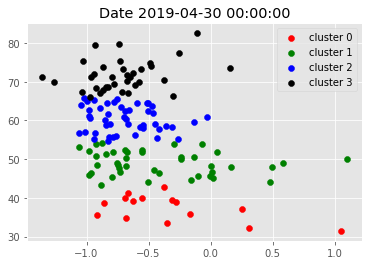

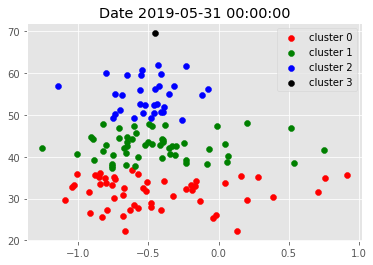

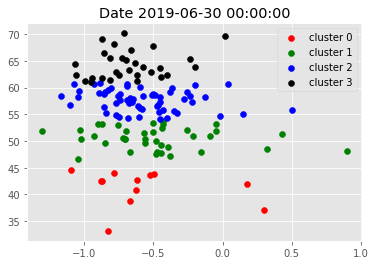

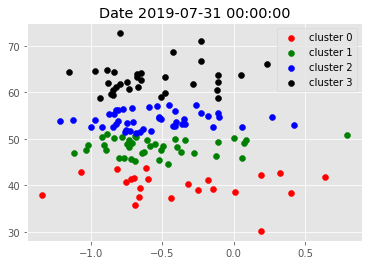

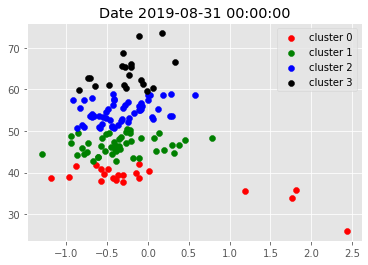

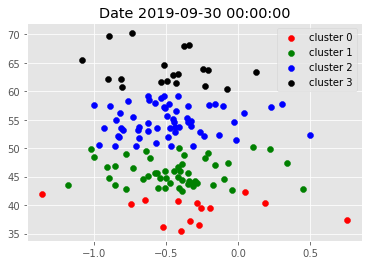

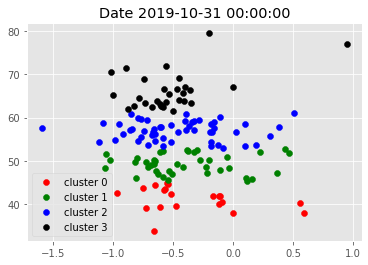

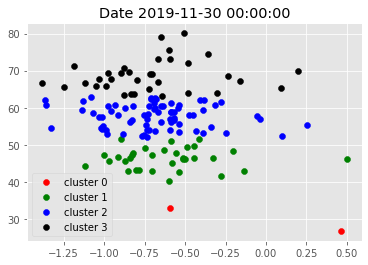

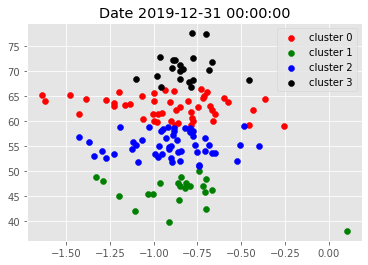

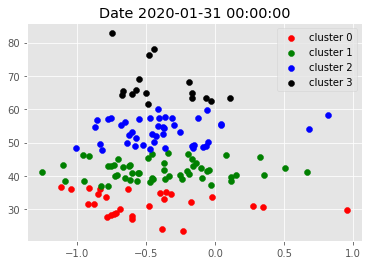

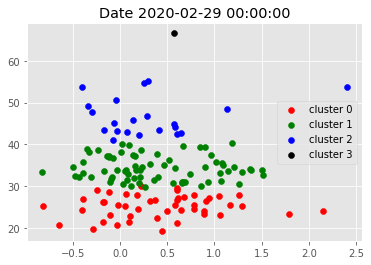

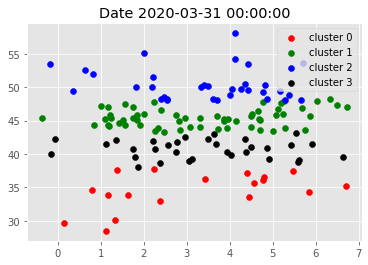

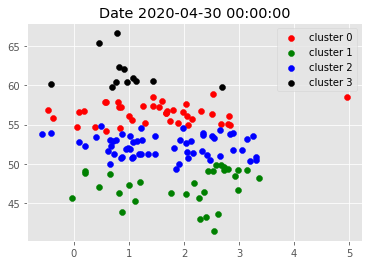

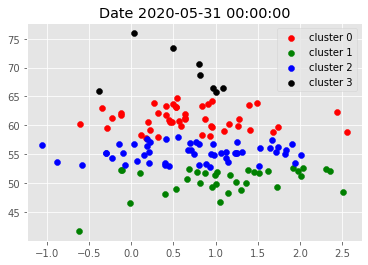

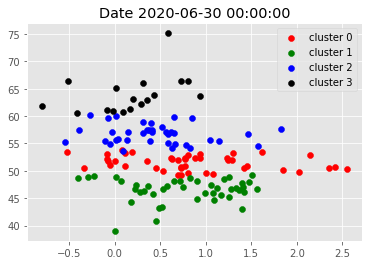

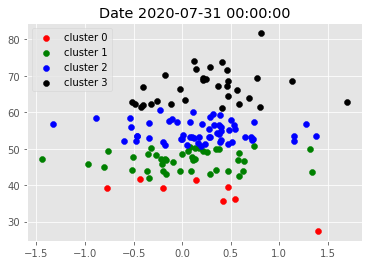

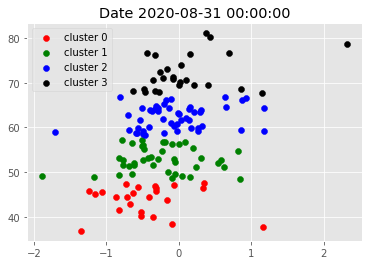

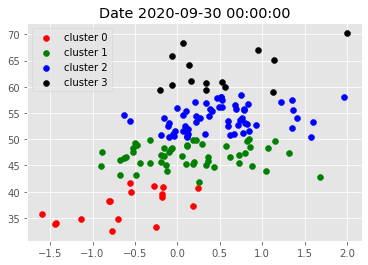

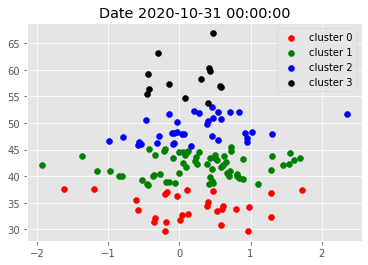

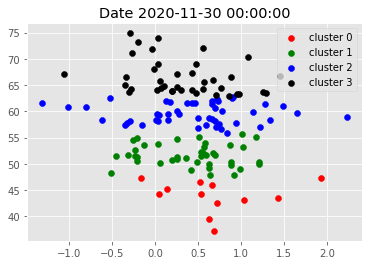

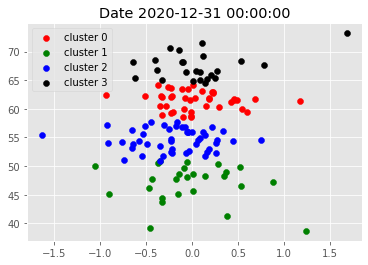

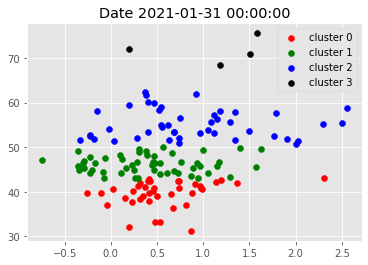

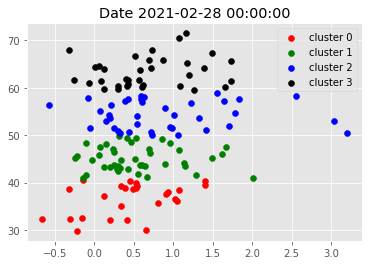

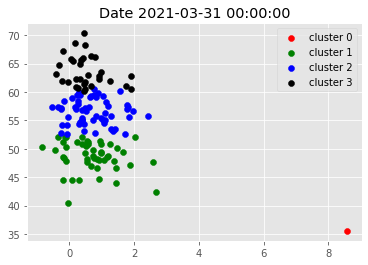

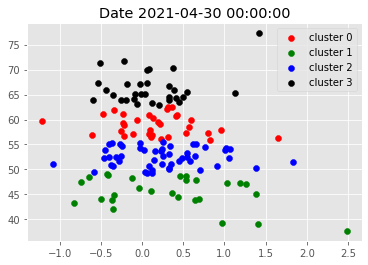

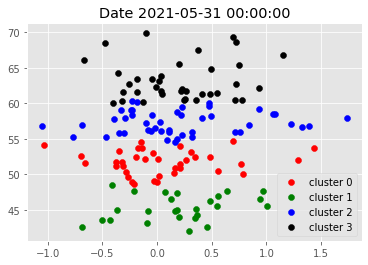

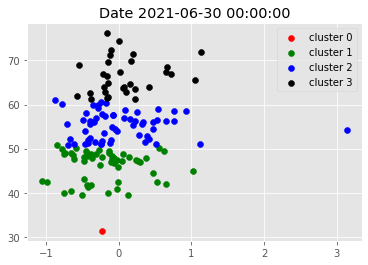

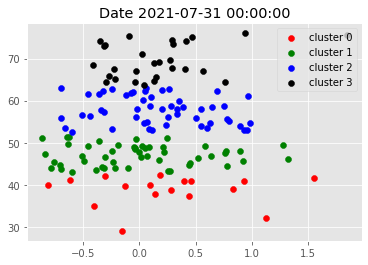

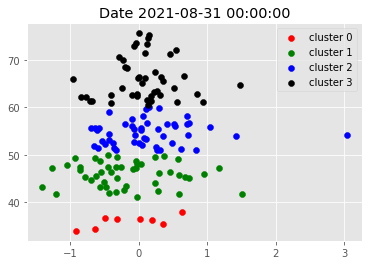

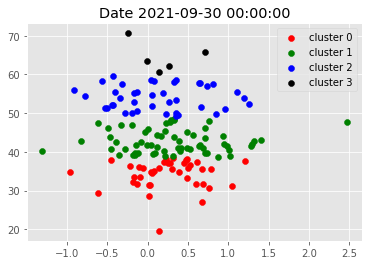

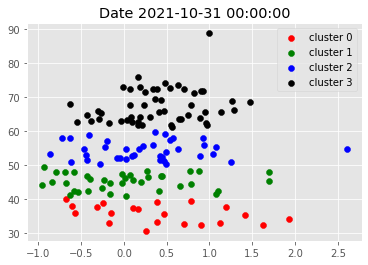

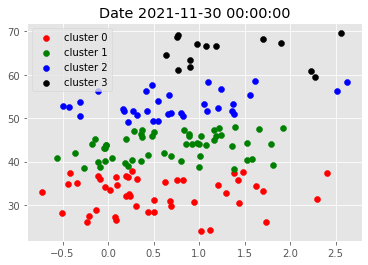

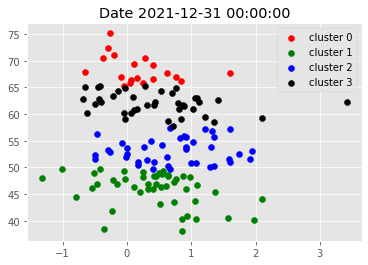

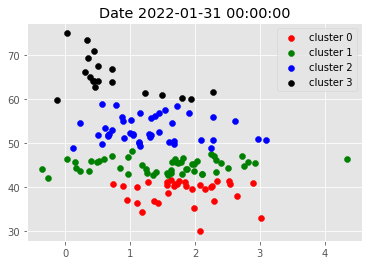

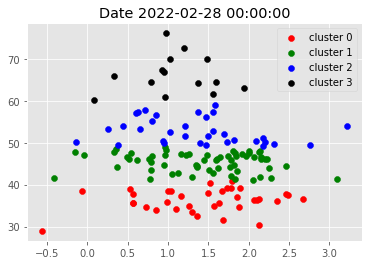

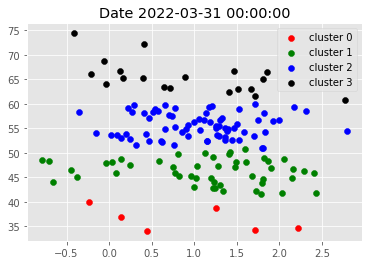

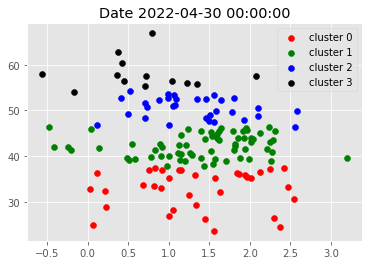

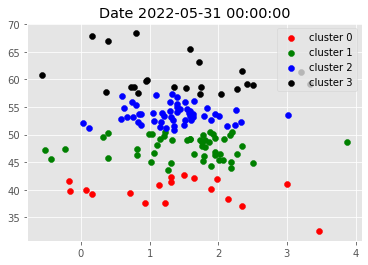

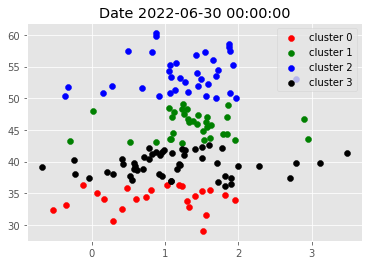

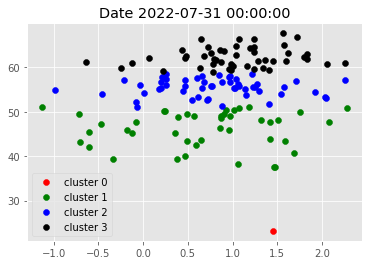

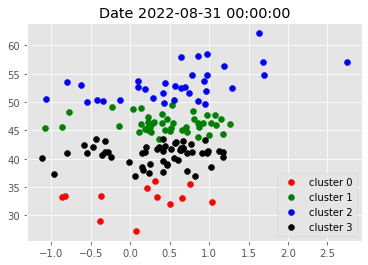

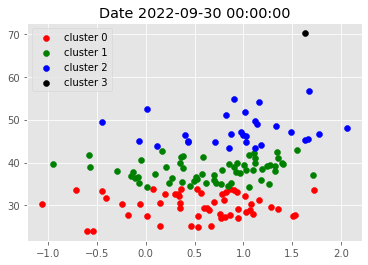

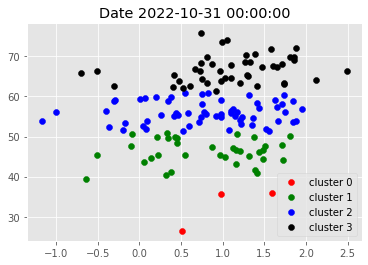

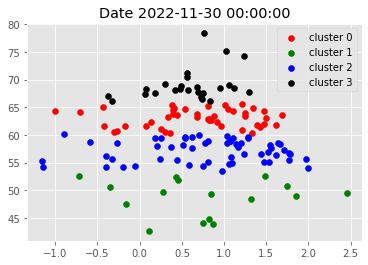

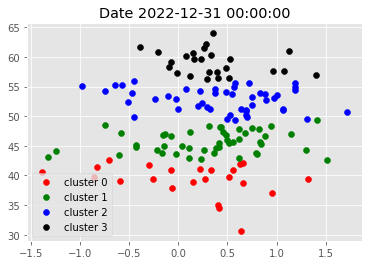

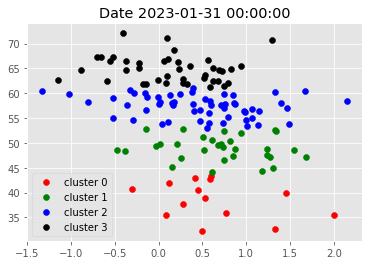

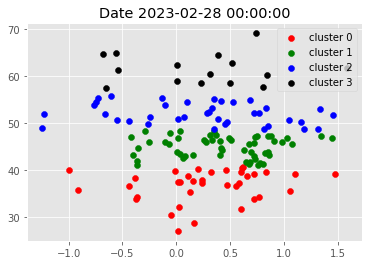

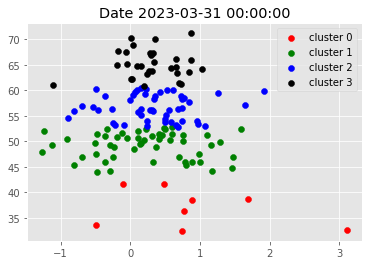

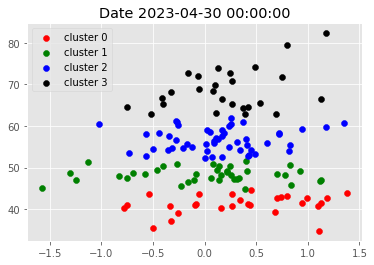

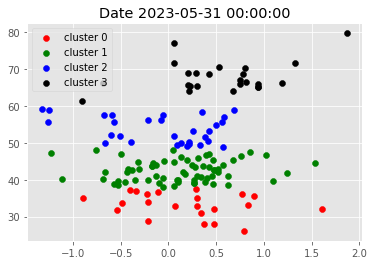

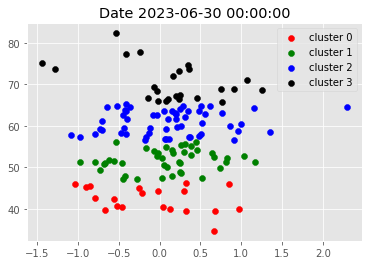

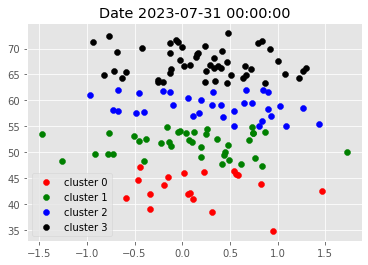

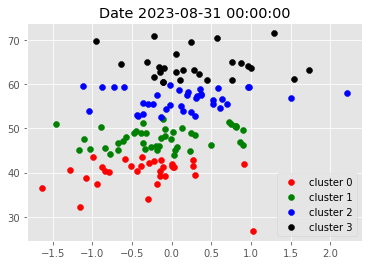

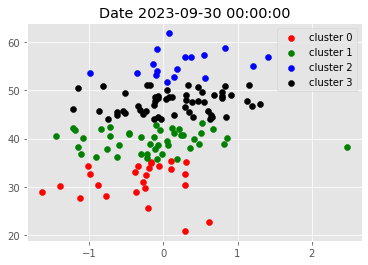

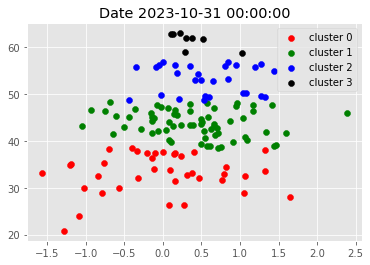

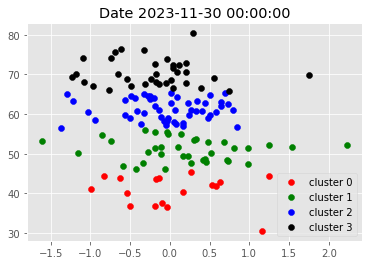

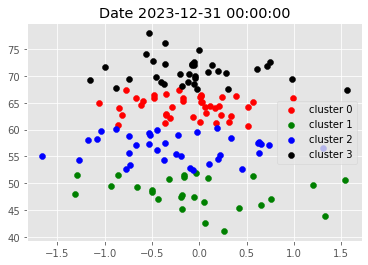

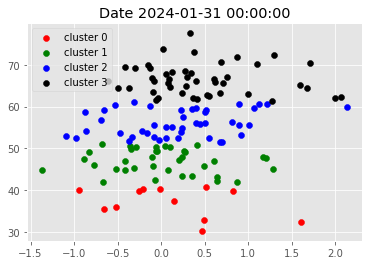

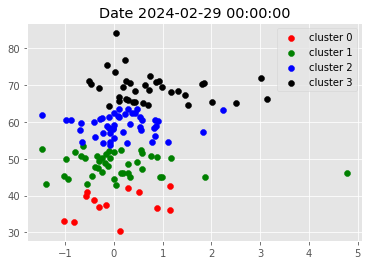

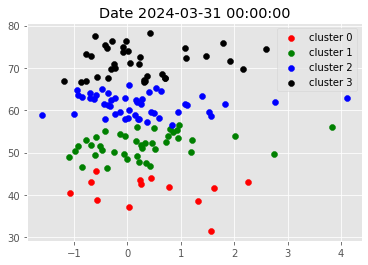

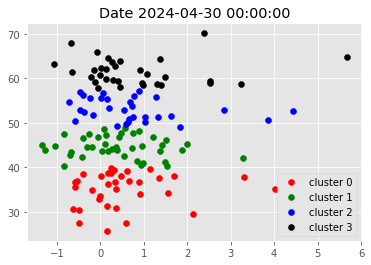

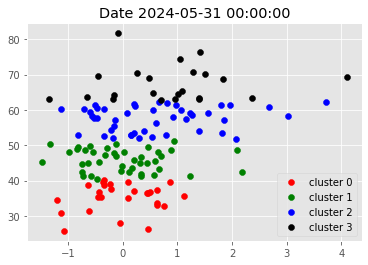

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

### Apply pre-defined centroids.

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [16]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2018-07-01': ['AMT',
  'BDX',
  'COST',
  'EA',
  'EOG',
  'KR',
  'NEE',
  'NFLX',
  'NKE',
  'PEP',
  'PG',
  'REGN',
  'SHW',
  'TJX'],
 '2018-08-01': ['ABT',
  'AMD',
  'AMGN',
  'AMT',
  'BDX',
  'BMY',
  'C',
  'CMCSA',
  'COST',
  'CSX',
  'DIS',
  'ELV',
  'EOG',
  'EXPE',
  'GILD',
  'HON',
  'JNJ',
  'JPM',
  'KO',
  'LLY',
  'LUV',
  'MDLZ',
  'MDT',
  'MMM',
  'MRK',
  'ORLY',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'QCOM',
  'REGN',
  'RTX',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'UNP',
  'UPS',
  'USB',
  'VLO',
  'WMT'],
 '2018-09-01': ['AAPL',
  'ABT',
  'ACN',
  'ADP',
  'AMD',
  'AMGN',
  'AMZN',
  'AZO',
  'BDX',
  'CMCSA',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'DAL',
  'DG',
  'ELV',
  'HUM',
  'ISRG',
  'LLY',
  'LOW',
  'LUV',
  'MA',
  'MDT',
  'MRK',
  'MSFT',
  'NVDA',
  'ORLY',
  'PANW',
  'PFE',
  'PYPL',
  'QCOM',
  'REGN',
  'SHW',
  'TGT',
  'TJX',
  'TMO',
  'UAL',
  'ULTA',
  'UNH',
  'UPS',
  'V',
  'VRTX',
  'WMT'],
 '2018-10-01': ['AB

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [17]:
!pip install PyPortfolioOpt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [18]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  156 of 156 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2017-06-30  48.838982   33.703403   53.369362   43.018230  111.341927   
2017-07-03  48.906918   33.581711   53.303108   43.106712  111.566994   
2017-07-05  49.751312   33.719784   53.347286   43.363350  111.675026   
2017-07-06  50.518063   33.401512   52.795254   42.425282  110.675766   
2017-07-07  51.469227   33.740845   53.016052   42.867779  111.819046   
...               ...         ...         ...         ...         ...   
2024-05-20  14.520000  191.039993  164.559998  103.209999  305.700012   
2024-05-21  14.030000  192.350006  162.929993  102.959999  303.640015   
2024-05-22  14.100000  190.899994  159.610001  104.820000  307.109985   
2024-05-23  13.820000  186.880005  158.259995  104.230003  305.929993   
2024-05-24  13.840000  189.979996  157.059998  103.949997  300.989990   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2017-06-30  141.440002   68.284981   88.898338  100.820000  52.191299  ...   
2017-07-03  138.410004   66.801666   88.863640   99.360001  52.834087  ...   
2017-07-05  141.210007   68.232300   90.295235  102.599998  52.408333  ...   
2017-07-06  140.750000   67.872459   89.748642  102.050003  52.658783  ...   
2017-07-07  142.220001   68.873024   91.223648  103.320000  52.884171  ...   
...                ...         ...         ...         ...        ...  ...   
2024-05-20  484.690002  217.479996  251.779999  221.399994  78.790001  ...   
2024-05-21  481.850006  216.639999  252.139999  220.279999  78.680000  ...   
2024-05-22  483.929993  240.160004  254.020004  219.960007  78.910004  ...   
2024-05-23  483.309998  234.559998  251.490005  215.160004  77.580002  ...   
2024-05-24  475.429993  232.509995  248.899994  214.889999  78.029999  ...   

Price        Volume                                                           \
Ticker            V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2017-06-30  9036600  2972000  1582300  13368900   7097300  6614900  16750700   
2017-07-03  6197700  2160000   825200   9732000   2419200  4562300  11825000   
2017-07-05  9339600  3938100  1320600  14853400   6481000  5119800  14086900   
2017-07-06  8215700  3332100  1171800  16854300   6011600  4143800  14481200   
2017-07-07  6175800  5083600  1019900  12198500   6001900  3436800  11503500   
...             ...      ...      ...       ...       ...      ...       ...   
2024-05-20  5460900  3089100   742200   8665000   6923900  5603200  15029000   
2024-05-21  6578200  2206800  1106700  18327000  25075400  4782000  18422100   
2024-05-22  4202500  2510000  1084600  12374100  12099500  3446900  10340500   
2024-05-23  6115900  2251400  1554700  14105000  16012300  5393000  13056100   
2024-05-24  4339700  1794500  1050600  10418800  10541200  2743100   9912500   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2017-06-30  20889900  1455000  14000600  
2017-07-03  14545800  2005600   8422300  
2017-07-05  18110700  1212300   9830800  
2017-07-06  18485400  1276900   9822400  
2017-07-07  15921300  1334800  10777800  
...              ...      ...       ...  
2024-05-20  15001400  1182200  11551300  
2024-05-21  17131700  1403800  14495000  
2024-05-22  14879400  1319000  17879300  
2024-05-23  16222900  1465100  15979800  
2024-05-24  11793800  1035400  12211400  

[1737 rows x 936 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [19]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2018-07-02,0.000664
2018-07-03,-0.005923
2018-07-05,0.008385
2018-07-06,0.008196
2018-07-09,0.000130
...,...
2024-05-20,0.003796
2024-05-21,0.007152
2024-05-22,-0.007977


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [20]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2018-07-02,0.000664,0.002136
2018-07-03,-0.005923,-0.003538
2018-07-05,0.008385,0.008125
2018-07-06,0.008196,0.008423
2018-07-09,0.000130,0.008964
...,...,...
2024-05-20,0.003796,0.001151
2024-05-21,0.007152,0.002450
2024-05-22,-0.007977,-0.002883
2024-05-23,-0.005457,-0.007331


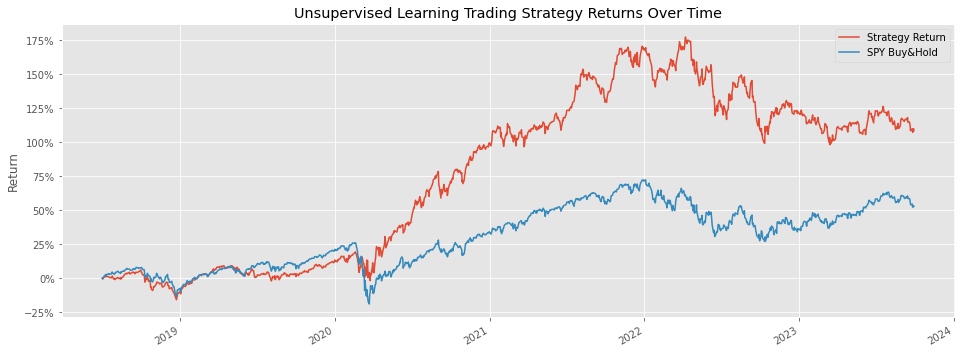

In [21]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = 'C:/Users/user/Desktop/Python Scripts'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [ ]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [ ]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [ ]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [ ]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

## 6. Calculate Portfolio Returns with monthly rebalancing


In [ ]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [ ]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

In [ ]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [ ]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = 'C:/Users/user/Desktop/Python Scripts'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [ ]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [ ]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

In [ ]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [ ]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

## 5. Generate the position entry and hold until the end of the day.

In [ ]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

In [ ]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            